In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os

IMAGES_DIR = "../images"
OUTPUTS_DIR = "../outputs"

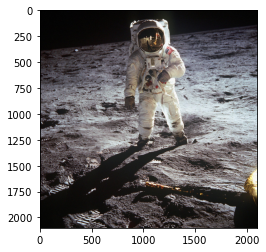

In [3]:
im1 = cv2.imread(os.path.join(IMAGES_DIR, 'moon.jpg'))
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
plt.imshow(im1, cmap="gray")
plt.show()

## Finding Edges from Depth Map

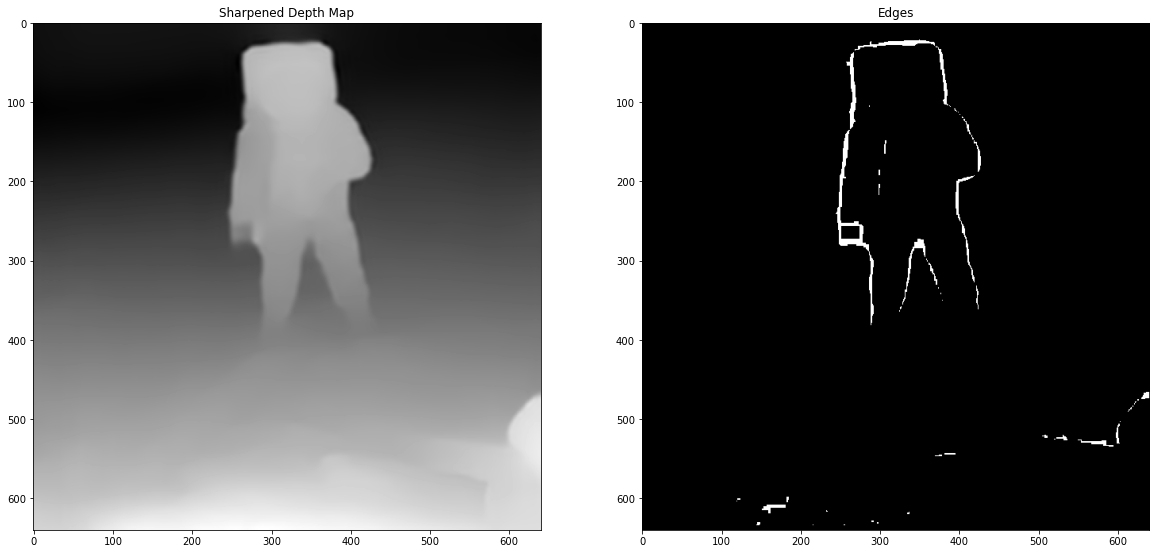

In [10]:
im1_depth = np.load(os.path.join(OUTPUTS_DIR, './moon.npy'))

# sharpening using bilateral filter
im1_depth = cv2.bilateralFilter(im1_depth, 7, 4, 0.5)
im1_depth = cv2.normalize(im1_depth,None,0,255,cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(im1_depth, cmap="gray")
plt.title("Sharpened Depth Map")

# finding edges
shift = 1
upshift = im1_depth[:-shift, :] - im1_depth[shift:, :]
downshift = im1_depth[shift:, :] - im1_depth[:-shift, :]
leftshift = im1_depth[:, :-shift] - im1_depth[:, shift:]
rightshift = im1_depth[:, shift:] - im1_depth[:, :-shift]

upshift = np.vstack((upshift, np.zeros((shift, im1_depth.shape[1]))))
downshift = np.vstack((np.zeros((shift, im1_depth.shape[1])), downshift))
leftshift = np.hstack((leftshift, np.zeros((im1_depth.shape[0], shift))))
rightshift = np.hstack((np.zeros((im1_depth.shape[0], shift)), rightshift))

kernel_size = 7
kernel = np.ones((kernel_size, kernel_size), np.uint8)
leftshift = cv2.morphologyEx(leftshift, cv2.MORPH_OPEN, kernel)
rightshift = cv2.morphologyEx(rightshift, cv2.MORPH_OPEN, kernel)
upshift = cv2.morphologyEx(upshift, cv2.MORPH_OPEN, kernel)
downshift = cv2.morphologyEx(downshift, cv2.MORPH_OPEN, kernel)

edges_tmp = np.logical_or(leftshift, rightshift)
edges_tmp = np.logical_or(edges_tmp, upshift)
edges_tmp = np.logical_or(edges_tmp, downshift)
edges_tmp = 255 * edges_tmp.astype(np.uint8)

kernel = np.ones((9,9), np.uint8)
depth_edges = cv2.erode(edges_tmp, kernel, iterations=1)

plt.subplot(122)
plt.imshow(depth_edges, cmap="gray")
plt.title("Edges")          
plt.show()

## Connected Components

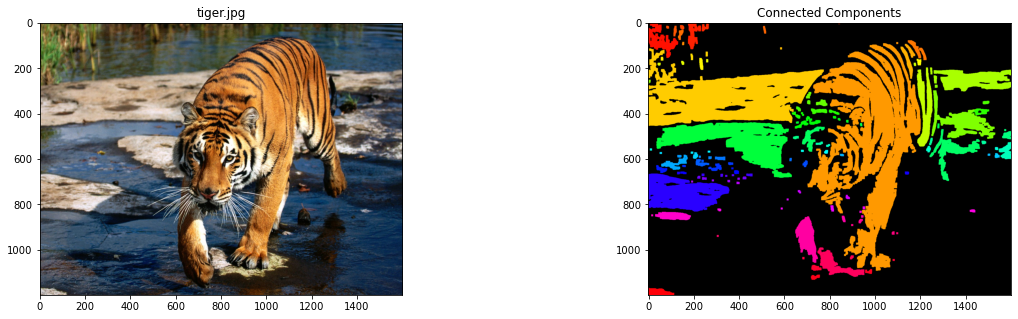

In [15]:
class Label: 
    def __init__(self, parent): 
        self.parent = parent    

def find(labelSets, node): 
    if labelSets[node].parent != node: 
        labelSets, labelSets[node].parent = find(labelSets, labelSets[node].parent) 
    return labelSets, labelSets[node].parent 

def union(labelSets, u, v):
    if u < v:
        labelSets[v].parent = u
    else:
        labelSets[u].parent = v
        
    return labelSets

def getNeighbors(labels, r, c, k):
    neighbors = []
    
    if r>0:
        neighbors.append(labels[r-1][c])
    if c>0:
        neighbors.append(labels[r][c-1])
    if r < labels.shape[0]-1:
        neighbors.append(labels[r+1][c])
    if c < labels.shape[1]-1:
        neighbors.append(labels[r][c+1])
    
    if k == 8:
        if r > 0 and c > 0 :
            neighbors.append(labels[r-1][c-1])
        if r > 0 and c < labels.shape[1]-1 :
            neighbors.append(labels[r-1][c+1])
        if r < labels.shape[0]-1 and c > 0 :
            neighbors.append(labels[r+1][c-1])
        if r < labels.shape[0]-1 and c < labels.shape[1]-1 :
            neighbors.append(labels[r+1][c+1])
    
    out = []
    for el in neighbors:
        if el != 0:
            if el not in out:
                out.append(el)
    return out

def getLabels(im, k):
    connLabels = {}
    labels = np.zeros(im.shape).astype(int)
    activeLabel = 1
    
    # Pass-1
    for row in range(im.shape[0]):
        for col in range(im.shape[1]):
            if im[row][col]:
                neighbors = getNeighbors(labels, row, col, k)
                if len(neighbors) == 0:
                    connLabels[activeLabel] = Label(activeLabel)
                    labels[row][col] = activeLabel
                    activeLabel += 1
                else:
                    labels[row][col] = min(neighbors)
                    curr = labels[row][col]
                    for n in neighbors:
                        if (n != curr):
                            connLabels = union(connLabels, n, curr)
    
    # Pass-2
    for row in range(im.shape[0]):
        for col in range(im.shape[1]):
            if im[row][col]:
                connLabels, labels[row][col] = find(connLabels, labels[row][col])
    
    uni = {}
    indx = 1
    uni[0] = 0
    for l in np.nditer(labels):
        if int(l) and (not int(l) in uni):
            uni[int(l)] = indx
            indx += 1
    
    k = np.array(list(uni.keys()))
    v = np.array(list(uni.values()))

    mapping_ar = np.zeros(k.max()+1,dtype=v.dtype)
    mapping_ar[k] = v
    out = mapping_ar[labels]
    
    return out

def getConnectedComp(im, thresh=127, k=8, kerSize=5, blurKernel=5):
    im = cv2.GaussianBlur(im, (blurKernel, blurKernel), 0)
    kernel = np.ones((kerSize, kerSize), int)
    im = cv2.erode(im, kernel, iterations = 2)
    im = cv2.dilate(im, kernel, iterations = 2)

    im = cv2.threshold(im, thresh, 255, cv2.THRESH_BINARY)[1]
    if len(im.shape) == 3:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im = im.astype(int)
    labels = getLabels(im, k)
    
    colored_labels = np.uint8(179 * labels / np.amax(labels))
    nothing = 255 * np.ones_like(colored_labels)
    out = cv2.merge([colored_labels, nothing, nothing])
    out = cv2.cvtColor(out, cv2.COLOR_HSV2RGB)
    out[colored_labels == 0] = 0
    
    return out, labels

im = cv2.imread(os.path.join(IMAGES_DIR, "tiger.jpg"))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im_gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(im)
plt.title("tiger.jpg")
plt.subplot(122)
plt.imshow(getConnectedComp(im_gray, thresh=100)[0])
plt.title("Connected Components")
plt.show()

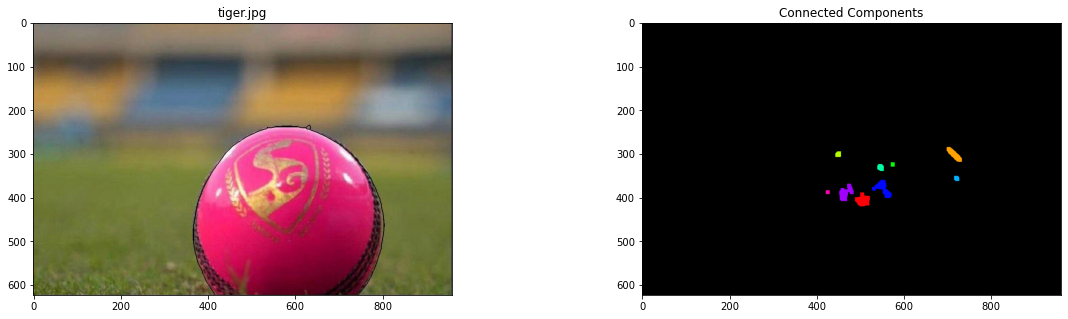

In [21]:
im = cv2.imread(os.path.join(OUTPUTS_DIR, "ball_out.jpeg"))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im_gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(im)
plt.title("tiger.jpg")
plt.subplot(122)
plt.imshow(getConnectedComp(im_gray, thresh=180)[0])
plt.title("Connected Components")
plt.show()